# Preprocess car data

In [1]:
import drz_config
cfg = drz_config.read_config()
DATE = cfg['DATE']
VERBOSE = cfg['VERBOSE']
OPBOD = cfg['OPBOD']
SKIPSAVE = cfg['SKIPSAVE']

if VERBOSE > 0:
    display(cfg)

{'settings_fn': '../code/assets/drz-auction-settings.ini',
 'DATE': '2021-06',
 'VERBOSE': 1,
 'OPBOD': False,
 'URL': 'http://verkoop.domeinenrz.nl/verkoop_bij_inschrijving_2021-0006',
 'EXTEND_URL': False,
 'CLOSEDDATA': True,
 'closed_data_fields': '*',
 'SKIPSAVE': False}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

## Load data

In [3]:
if OPBOD:
    fn = '../../../python-nb/data/cars-from-all-auctions-opbod.pkl'
else:
    fn = '../data/cars-from-all-auctions.pkl'
print(fn)
car = pd.read_pickle(fn)

if VERBOSE > 0:
    display(car.tail())

../data/cars-from-all-auctions.pkl


,LotNr,Price,Title,LotCat,LotType,ItemBrand,ItemType,Mfdate,Mfyear,APKdate,...,rdw_assen_aangedreven_as_4,rdw_assen_hefas_4,rdw_assen_plaatscode_as_4,rdw_assen_weggedrag_code_4,rdw_ovi_tenaamstellen_mogelijk,disclaim6,rdw_tellerstandoordeel,rdw_code_toelichting_tellerstandoordeel,rdw_tenaamstellen_mogelijk,rdw_jaar_laatste_registratie_tellerstand
2021-06-7175,K2100067175,4500.0,Kavel K2100067175,Voertuigen en onderdelen,Personenauto,VOLKSWAGEN,golf,19.03.2015,,,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
2021-06-7176,K2100067176,3486.0,Kavel K2100067176,Voertuigen en onderdelen,Personenauto,VOLKSWAGEN,up,24.06.2013,,,...,NaN,NaN,NaN,NaN,Ja,False,Logisch,00,Ja,2021.0
2021-06-7178,K2100067178,999.0,Kavel K2100067178,Voertuigen en onderdelen,Personenauto,PEUGEOT,207,26.09.2008,,27.10.2021,...,NaN,NaN,NaN,NaN,Ja,False,Logisch,00,Ja,2021.0
2021-06-7179,K2100067179,8105.0,Kavel K2100067179,Voertuigen en onderdelen,Personenauto,AUDI,audi q5,15.01.2009,,15.01.2022,...,NaN,NaN,NaN,NaN,Ja,False,Logisch,00,Ja,2021.0
2021-06-7181,K2100067181,839.0,Kavel K2100067181,Voertuigen en onderdelen,Personenauto,OPEL,corsa,29.08.2007,,,...,NaN,NaN,NaN,NaN,Ja,False,Logisch,00,Ja,2021.0


### Rename columns
to keep track of source of field

In [4]:
car.rename(columns={
    'rhd': 'rhd_drz',
    'automatic': 'automatic_drz',
    'hybrid': 'hybrid_drz',
    'taxi': 'taxi_drz',
    'ItemType': 'model_drz',
    'ItemBrand': 'brand_drz',
}, inplace=True)

## Odometer
convert miles to km and make all numerical

In [5]:
def odo_str2float(df):
    '''
    Convert odometer to numerical values.
    Also convert Miles to KMs.
    '''
    
    ml2km = 1.609344
    
    # substitute to nan
    for repair_to_nan in ['onbekend', 
                          'volgens NAP logisch', 'volgens nap logisch', 
                          'volgens NAP onlogisch', 'volgens nap onlogisch']:
        df.OdoKM = df.OdoKM.apply(lambda x:x.replace(repair_to_nan,'nan') if (type(x) == str) and (len(x)>0) else 'nan')
        df.OdoMLS = df.OdoMLS.apply(lambda x:x.replace(repair_to_nan,'nan') if (type(x) == str) and (len(x)>0) else 'nan')
    # float
    df["OdoKM_num"] = df.OdoKM.apply(lambda x:x.replace('.','')).astype(float)
    df["OdoMLS_num"] = df.OdoMLS.apply(lambda x:x.replace('.','')).astype(float)
    # convert miles to km
    df["Odo"] = df.OdoKM_num.copy()
    chooseMls = (df.OdoKM_num.isna()) & ~(df.OdoMLS_num.isna())
    df.loc[chooseMls,"Odo"] = df.loc[chooseMls,"OdoMLS_num"].apply(float) * ml2km

,Odo,OdoKM,OdoKM_num,OdoMLS,OdoMLS_num
2017-3-2000,23982.0,23982,23982.0,nan,NaN
2017-3-2001,81459.0,81459,81459.0,nan,NaN
2017-3-2002,31932.0,31932,31932.0,nan,NaN
2017-3-2003,84145.0,84145,84145.0,nan,NaN
2017-3-2004,27248.0,27248,27248.0,nan,NaN
...,...,...,...,...,...
2021-06-7175,118686.0,118.686,118686.0,nan,NaN
2021-06-7176,110616.0,110.616,110616.0,nan,NaN
2021-06-7178,283224.0,283.224,283224.0,nan,NaN
2021-06-7179,259372.0,259.372,259372.0,nan,NaN


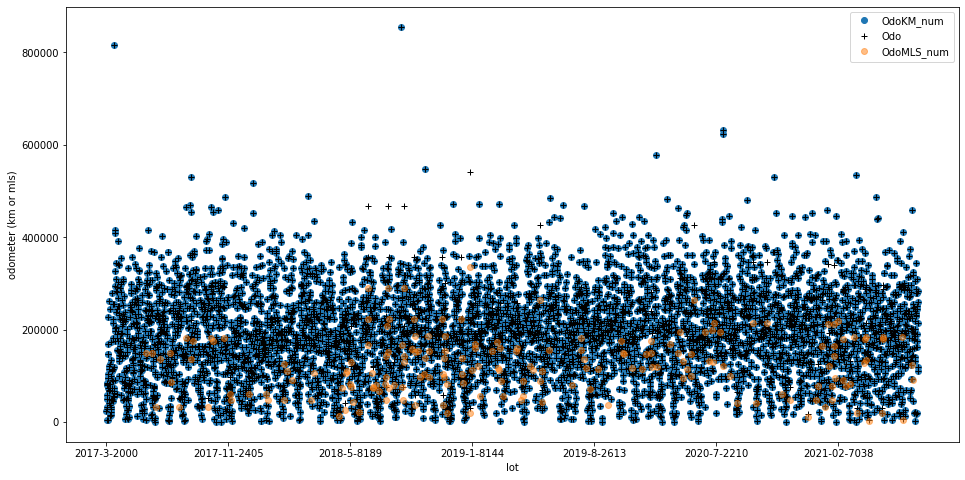

In [6]:
# do conversion
odo_str2float(car)

if VERBOSE > 0:
    # print new column and source info
    display(car.loc[:,['Odo','OdoKM','OdoKM_num','OdoMLS','OdoMLS_num']])

    # plot odometer
    fig,ax=plt.subplots(figsize=[16,8])
    ax.set_xlabel('lot')
    ax.set_ylabel('odometer (km or mls)')

    car.loc[:,["OdoKM_num"]].plot(marker='o',linestyle='',alpha=1,ax=ax)
    car.loc[:,["Odo"]].plot(marker='+',color='k',linestyle='',alpha=1,ax=ax)
    car.loc[:,["OdoMLS_num"]].plot(marker='o',linestyle='',alpha=.5,ax=ax)


## Model and brand

Enforce some consistency in naming


In [7]:
# Rename to conventional brand name
car.brand_drz.replace({
    "ASTON MARTIN":"ASTON-MARTIN",
    'AUTO UNION':'AUDI',
    'JAGUAR CARS':'JAGUAR',
    "MERCEDES BENZ":"MERCEDES-BENZ",
    "MERCEDES":"MERCEDES-BENZ",
    "MICRO COMPACT CAR SMART":"SMART",
    "MICRO COMPACT CAR":"SMART",
    "LANDROVER": "LAND ROVER",
    "LAND-ROVER": "LAND ROVER",
    "CITRO": "CITROËN",
    "CITROÃÂ\x8bN": "CITROËN",
},inplace=True)


# When brand name has a specification that needs to go in the model name.
# E.g. Mercedes <AMG> and Audi <QUATTRO>
def add_model_spec(s,spec):
    '''Adds specification at the end of the model name if not already in name'''
    import re 
    
    # addition should not exist
    if not re.search('(?i)' + spec, s):
        
        # add separator
        if not (s.endswith(';')):
            s += ';'
        # add specification
        s += ' ' + spec
    return s

sel = car.brand_drz == 'QUATTRO'
car.loc[sel,'model_drz'] = car.loc[sel,'model_drz'].apply(lambda s: add_model_spec(s,'quattro'))
car.loc[sel,'brand_drz'] = 'AUDI'

sel = car.brand_drz == 'MERCEDES-AMG'
car.loc[sel,'model_drz'] = car.loc[sel,'model_drz'].apply(lambda s: add_model_spec(s,'amg'))
car.loc[sel,'brand_drz'] = 'MERCEDES-BENZ'

sel = car.brand_drz == "ALPINA"
car.loc[sel,'model_drz'] = car.loc[sel,'model_drz'].apply(lambda s: add_model_spec(s,'alpina'))
car.loc[sel,'brand_drz'] = 'BMW'


In [8]:
import html
car["model_drz"] = car.model_drz.fillna('').apply(lambda s: html.unescape(s))


In [9]:
car.loc[:, 'modelspec_drz'] = ''
car.update(
    car.model_drz.str.split(pat=';', expand=True, n=1).fillna('').rename(columns={0: 'model_drz', 1: 'modelspec_drz'})
)

### Concatenate columns with index numbers

In [10]:
def _split_indexnr(c):
    M = re.match(r'^(rdw_[a-z,_,]+)(_cm3)?((_[0-9]+)+)$', c)
    if M is None:
        return None
    
    return M[0], M[1] + (M[2] if M[2] is not None else ''), M[3]


## Example
# cs = [
#     'rdw_motor_uitvoering_cilinderinhoud_cm3_1',
#     'rdw_motor_uitvoering_cilinderinhoud_cm3_2',
#     'rdw_motor_uitvoering_cilinderinhoud_cm3_3',
#     'rdw_motor_uitvoering_brandstof_emissie_stikstofoxide_type_1_1_1',
#     'rdw_motor_uitvoering_brandstof_brandstofverbruik_stadsrit_3_1_1',
#     'rdw_motor_uitvoering_brandstof_brandstofverbruik_stadsrit_3_1'
# ]
# pd.DataFrame([_split_indexnr(c) for c in cs], columns=['old', 'new', 'counter'])

In [11]:
def _prog(cur, end, last=0):
    
    pct = cur/end
    
    if pct > last/100:
        print(f'{last}%')
        last += 10 # every 10% an update
    elif cur >= end:
        print('done')
    else:
        print('.', end='')
    
    return last

## Example
# last = _prog(11,100,10)
# last = _prog(12,100,last)
# last = _prog(13,100,last)

In [12]:
# Get info from dataframe columns
new_names = np.array([i[1] + '_concat' for i in map(_split_indexnr, car.columns) if i is not None])
old_names = np.array([i[0] for i in map(_split_indexnr, car.columns) if i is not None])
counter = np.array([i[2] for i in map(_split_indexnr, car.columns) if i is not None])

if 2 > VERBOSE > 0:
    # initiate progress bar
    last = 0
for prg, new_name in enumerate(set(new_names)):
    
    # select columns in df
    sel = new_names == new_name
    
    # make dict from columns
    new_dicts = car[old_names[sel]].apply(lambda row: {
        k[1:]: v # {'1_1_1': 'value'}, "[1:]" to trim off leading "_" 
        for k,v in zip(counter[sel], row) 
        if ~((isinstance(v,float)) and (np.isnan(v)))
    }, axis=1)
    
    # add series to new column 
    car[new_name] = new_dicts
    
    # Remove old columns
    car.drop(columns=old_names[sel], inplace=True)
    
    # progress
    if 2 > VERBOSE > 0:
        last = _prog(prg, len(set(new_names)), last)
    elif VERBOSE > 1:
        print(f'{counter[sel][0]:7s} .. {counter[sel][-1]:7s} ({sum(sel):3.0f}) -> {new_name:s}')
        


.0%
..............10%
..............20%
...............30%
..............40%
...............50%
..............60%
..............70%
...............80%
..............90%
..............

In [13]:
if VERBOSE > 1:
    # Unknown registrations
    # Might be able to fix it by looking at the raw text.
    ixs = car.loc[car.Reg.str.lower() == 'onbekend'].index
    display(car.loc[ixs,['Reg','ForeignReg']])
    for ix in ixs:
        print(ix,end='\n\t')
        rt = car.loc[ix,'Raw_text']
        if type(rt) == list:
            print('\n\t'.join(rt))
        else:
            print(rt)

if VERBOSE > 1:
    # FUTURE: Do something with foreign registrations
    # Parsing did not always get it right.
    list(car.ForeignReg.unique())


if VERBOSE > 1:
    # Steering wheel in center? "M"?
    display(car.loc[car.rdw_basisgegevens_kant_van_het_stuur == 'M', 'Raw_text'])

    # De zijde van het voertuig waar het stuurwiel is gemonteerd.
    # Waarden 
    # L     Links
    # R    Rechts
    # M    Midden
    # src: https://www.rdw.nl/-/media/rdw/rdw/pdf/sitecollectiondocuments/over-rdw/naslagwerk/beschrijving-dataset-typegoedkeuring-v10.pdf
    # car.rdw_basisgegevens_kant_van_het_stuur.value_counts()



## Other repairs

In [14]:
# reparse raw text NAP
# Wrong ones have 'isch'

# re pattern
patt = '^Km-stand volgens nap (?P<val>(logisch)|(onlogisch))$'
# loop over wrong ones
for ix in car[car.NAP == 'isch'].index:
    # line by line
    for line in car.loc[ix,'Raw_text']:
        M = re.match(patt,line)
        if M:
            car.loc[ix,"NAP"] = M.group('val')
            
            
# Year of manufacturing unknown
# Mfyear: "onbekend"
car.Mfyear.replace('onbekend','', inplace=True)

## Adhoc repair

When all fails

In [15]:
if OPBOD:
    print('skip')
else:
    # '2603 Afkomstig van JFC HQ Brunssum.'
    ix='2017-5-2603'
    car.loc[ix,"LotNr"] = '2603'
    car.loc[ix, 'jfc'] = True
    # K2000098227 Afkomstig van JFC HQ Brunssum.
    ix='2020-9-8227'
    car.loc[ix,"LotNr"] = '8227'
    car.loc[ix, 'jfc'] = True
    
    # "bouwjaar verklaring noodzakelijk."
    # car.loc[[v=="verklaring noodzakelijk." for v in car.Mfyear]]
    # car[car.Mfyear.str.contains('verklaring noodzakelijk.')==True]
    ixs = ['2020-1-7177']
    for ix in ixs:
        car.loc[ix, 'Mfyear'] = ''

    # fix issus with one lot that has no type
    # print(car.model_drz[~ (car.model_drz.apply(type) == str)])
    # [print(l) for l in eval(car.loc['2017-6-7121','Raw_text'])]
    # car.loc['2017-6-7121','Images']
    ix = '2017-6-7121'
    car.loc[ix,'model_drz'] = 'golf'

    # car.loc[car.brand_drz == 'Kampeerwagen/camper',:]
    # car.loc["2017-5-2408",:]
    ix = '2017-5-2408'
    #car.loc[ix,'brand_drz'] = 'VOLKSWAGEN'
    car.drop(ix,inplace=True) # remove alltogether


    # car.loc[car.brand_drz == 'AUDI A4',:]
    ix = '2018-6-7195'
    car.loc[ix,'brand_drz'] = 'AUDI'
    car.loc[ix,'model_drz'] = 'a4; ' + car.loc[ix,"model_drz"]
    # car.loc[car.brand_drz.str.contains('PANAMERA'), ['brand_drz', 'brand_rdw', 'brand_rdwovi', 'model_drz', 'model_rdw', 'model_rdwovi', 'modelspec_drz']]
    ix = '2019-6-2408'
    car.loc[ix, 'brand_drz'] = 'PORSCHE'
    car.loc[ix, 'model_drz'] = 'panamera; ' + car.loc[ix, 'model_drz']

    # car.loc[car.brand_drz == 'MINI COOPER',:]
    ix = '2018-10-2210'
    car.loc[ix,'brand_drz'] = 'MINI'
    car.loc[ix,'model_drz'] = 'cooper; ' + car.loc[ix,"model_drz"]
    
    # car.loc[car.brand_drz == 'DAIMLERCHRYSLER AG', ['Reg', 'brand_drz', 'rdw_merk', 'rdw_ovi_merk', 'model_drz', 'Raw_text']]
    ixs = ['2019-9-9262', '2019-11-8141']
    for ix in ixs:
        car.loc[ix,'brand_drz'] = 'MERCEDES-BENZ'

    # car.loc[car.model_drz == 'benz',:]
    # car.loc[ix,'Images']
    # This is a w204 mfyear < 2011
    ix = '2017-5-2618'
    car.loc[ix,'model_drz'] = 'c cdi'

    # car.loc["2018-1-3046","Raw_text"]
    # This is combined lot
    car.drop("2018-1-3046",inplace=True) # remove alltogether

    # car.ForeignReg=='Het voertuig is voorzien van taxi-kentekenplaten. Taxiregistratie kunt u laten be&#235;indigen via de RDW. Vervanging van de blauwe door gele'
    # Taxi
    ixs = ['2017-11-8302', '2017-11-8305', '2018-1-8163']
    regs = ['54-GLL-5','57-XZ-FV','70-TLF-3']
    for ix,reg in zip(ixs,regs):
        car.loc[ix,'taxi_drz'] = True
        car.loc[ix,'Reg'] = reg

    # Typo in registration K1900022009
    # 8-SKL-15 not 8-SLK-15
    ix = '2019-2-2009'
    car.loc[ix,'Reg'] = '8-SKL-15'
    if car.loc[ix,'rdwinfo']['kenteken'][0] == '8SLK15':
        car.loc[ix,'rdwinfo'] = None

    # NAP is provided first and impacts Odometer reading
    ixs = ['2019-9-9106', '2019-9-9249']
    naps = ['logisch', 'onlogisch']
    kms = ['251.571', '', '']
    #display(car.loc[ixs,['NAP', 'OdoKM', 'Raw_text']])
    for ix,nap,km in zip(ixs,naps,kms):
        car.loc[ix,'NAP'] = nap
        car.loc[ix,'OdoKM'] = km
        
    
    # Text in lot was missing a character: "58.83"
    ix = '2020-12-7138'
    car.loc[ix, 'OdoKM'] = '58.683'
    
    # date format is different
    ix = '2020-12-7263'
    car.loc[ix, 'Mfdate'] = car.loc[ix, 'Mfdate'].replace('-','.')
    
    # Typo
    # car.loc[car.brand_drz == 'MERCDES-BENZ',:]
    ix = '2018-9-8162'
    car.loc[ix,'brand_drz'] = 'MERCEDES-BENZ'
    # car[car.brand_drz == 'VOLKWAGEN']
    ixs = ['2020-8-2615', '2020-12-7302']
    for ix in ixs:
        car.loc[ix, 'brand_drz'] = 'VOLKSWAGEN'
    # car[car.brand_drz == 'CITROEN']
    ix = '2020-1-7163'
    car.loc[ix, 'brand_drz'] = 'CITROËN'
    

- - - - 
## Make data type consistent

In [16]:
def string_to_list_images(s):
    '''Convert string to list'''
    if type(s) == str:
        s=s.replace('[',"['",1)
        s=s[::-1].replace(']',"]'",1)[::-1]
        s=eval(s.replace(', ',"' , '"))
        
    return s

def string_to_int_lotnr(s):
    '''Convert string to int'''
    if type(s) == str:
        if s[0] == 'K':
            # "K1800092200"
            s=int(s[-4:])
        else:
            s=int(s)
        
    return s

def string_to_list_rawtext(s):
    '''Convert string to list'''
    if type(s) == str:
        if s[1] == "'":
            s=eval(s)
        else:
            s=string_to_list_images(s)
        
    return s

def parse_cm(s):
    if not isinstance(s, str):
        return s
    tokens = re.findall('^\s*([0-9,\.,\,]+)\s*cm|CM', s)
    if len(tokens) == 0:
        return s
    elif len(tokens) > 1:
        print(tokens)
        raise Exception('fix this. too many results')
        return s
    return tokens[0]

def parse_kg(s):
    if not isinstance(s, str):
        return s
    tokens = re.findall('^\s*([0-9,\.,\,]+)\s*kg|KG', s)
    if len(tokens) == 0:
        return s
    elif len(tokens) > 1:
        print(tokens)
        raise Exception('fix this. too many results')
        return s
    return tokens[0]

def parse_euro(s):
    if not isinstance(s, str):
        return s
    tokens = re.findall('^€\s*([0-9,\.,\,]+)', s)
    if len(tokens) == 0:
        return s
    elif len(tokens) > 1:
        print(tokens)
        raise Exception('fix this. too many results')
        return s
    return tokens[0]

def parse_jn(s):
    return s.replace({'Ja': True, 'Nee': False})

def str_to_upper(s):
    return s.str.upper()


In [17]:
# Convert to the same data type

car.Images = car.Images.apply(lambda r: string_to_list_images(r))
car.LotNr = car.LotNr.apply(string_to_int_lotnr)
car.Raw_text = car.Raw_text.apply(string_to_list_rawtext)

In [18]:
# parse string .. cm, EUR .. ..kg etc
car.update(car.apply({
    'rdw_ovi_afstand_voorzijde_vrtg_tot_hartkoppeling': parse_cm,
    'rdw_ovi_cilinder_inhoud': parse_cm,
    'rdw_ovi_wielbasis': parse_cm,
    
    'rdw_ovi_bpm_bedrag': parse_euro,
    'rdw_ovi_catalogus_prijs': parse_euro,
    
    'rdw_ovi_massa_bedrijfsklaar': parse_kg,
    'rdw_ovi_massa_ledig_voertuig': parse_kg,
    'rdw_ovi_maximum_massa_geremd': parse_kg,
    'rdw_ovi_maximum_massa_ongeremd': parse_kg,
    'rdw_ovi_maximum_massa_samenstel': parse_kg,
    'rdw_ovi_maximum_massa_voertuig': parse_kg,
    'rdw_ovi_technische_maximum_massa_voertuig': parse_kg,
    
    'rdw_wam_verzekerd': parse_jn, 
    'rdw_openstaande_terugroepactie_indicator': parse_jn, 
    'rdw_export_indicator': parse_jn, 
    'rdw_taxi_indicator': parse_jn, 
    'rdw_retrofit_roetfilter': parse_jn, 
    'rdw_ovi_wachten_op_keuring': parse_jn, 
    'rdw_ovi_w_a_verzekerd': parse_jn, 
    
    'rdw_ovi_kleur': str_to_upper,
}))


In [19]:
# convert 1/0 to Booleans 
# nan: False
# empty string : maintain

for c in ['automatic_drz','cabriolet','rhd_drz','no_road','crewcab','carwrap','d_lic',
          'benzine','diesel','lpg','electric','hybrid_drz',
          'jfc','locked','no_key','no_cvo','no_igk','no_odo','wo_frame','used_parts', 'legguard', 
          'import','early_reg','maybe_reg','no_inireg','no_nlreg193','no_nlreg194', 'no_nlreg19', 'no_orireg','no_reg','no_regneeded','no_rdw','rdw150','no_vin','btw21',
          'disclaim1','disclaim2','disclaim12','disclaim3','disclaim4', 'disclaim5', 'disclaim_cr6']:
    
    assert c in car.columns
    ## Debug
    # if c not in car.columns:
    #     print('skip', c)
    #     continue

    car[c] = car[c].replace({0:False,1:True}).fillna(False)

In [20]:
# Get last query from list of rdw querries
if 'rdwinfo' not in car.columns:
    print('skip')
else:
    last_query = car.rdwinfo.apply(lambda x:pd.to_datetime([i['TimeStamp'] for i in x],format='%Y%m%d').argmax() if type(x) == list else np.NaN)
    for queries,last,idx in zip(car.rdwinfo,last_query,car.index):
        if np.isnan(last):
            continue
        car.loc[idx,'rdwinfo'] = [queries[int(last)]]

### Fill empty

In [21]:
car.Draw = car.Draw.fillna(False)
car.Mfyear = car.Mfyear.replace('',np.NaN).fillna(-1).astype(int)
car.Note = car.Note.astype(str)

In [22]:
# replace "niet geregistreerd" with nan
rep_cols = [c for c in car.columns if c.startswith('rdw_')]
car[rep_cols] = car[rep_cols].replace({
    'Niet geregistreerd': np.NaN,
    'Geen verstrekking in Open Data': np.NaN,
})

In [23]:
# Lists
# NaN: [] (empty list)
cols = [
    'rdw_merk_registratie_datum', 
    'rdw_merkcode',
]
# Should exist in dataframe
assert len(set(cols).difference(car.columns)) == 0
## Debug
# print('skip', np.setdiff1d(cols, car.columns))

car.loc[:,cols] = car.loc[:,cols].applymap(lambda x: [] if ((not isinstance(x, list)) and pd.isna(x)) else x)




# Integers
# NaN: -1
cols = [
    'N_images',
    'rdw_aantal_cilinders',
    'rdw_aantal_deuren',
    'rdw_basisgegevens_aantal_deuren_bovengrens',
    'rdw_basisgegevens_aantal_deuren_ondergrens',
    'rdw_aantal_rolstoelplaatsen',
    'rdw_aantal_wielen',
    'rdw_basisgegevens_aantal_wielen',
    'rdw_aantal_zitplaatsen',
    'rdw_basisgegevens_aantal_zitplaatsen_bovengrens',
    'rdw_basisgegevens_aantal_zitplaatsen_ondergrens',
    'rdw_basisgegevens_aantal_aangedreven_assen',
    'rdw_uitvoering_wijzigingsnummer',
    'rdw_eeg_basis_goedkeuringsnummer',
    'rdw_eeg_uitbreiding_goedkeuringsnummer',
    'rdw_ovi_aantal_assen',
    'rdw_ovi_aantal_cilinders',
    'rdw_ovi_aantal_rolstoelplaatsen', #Niet geregistreerd
    'rdw_ovi_aantal_wielen',
    'rdw_ovi_aantal_zitplaatsen', #Niet geregistreerd
    'rdw_ovi_aantal_deuren', 
    'rdw_ovi_afstand_voorzijde_vrtg_tot_hartkoppeling', #Niet geregistreerd ".. cm"
    'rdw_ovi_cilinder_inhoud', #Niet geregistreerd ".. cm^3"
    'rdw_ovi_wielbasis', #..cm
    'rdw_ovi_bpm_bedrag', # eur ..
    'rdw_ovi_catalogus_prijs', #Niet geregistreerd "EUR .."
    'rdw_ovi_massa_bedrijfsklaar', #' ..kg'
    'rdw_ovi_massa_ledig_voertuig', #..kg
    'rdw_ovi_maximum_massa_geremd', #..kg
    'rdw_ovi_maximum_massa_ongeremd', #..kg
    'rdw_ovi_maximum_massa_samenstel', #..kg
    'rdw_ovi_maximum_massa_voertuig', #..kg
    'rdw_ovi_technische_maximum_massa_voertuig', #..kg
    'rdw_ovi_tellerstand_datum', #yyyy
]

# Should exist in dataframe
assert len(set(cols).difference(car.columns)) == 0
## Debug
# print('skip', np.setdiff1d(cols, car.columns))

car.loc[:,cols] = car.loc[:,cols].fillna(-1).astype(int)




# Strings
# NaN: ''
cols = [
    'APKdate', 
    'BTW', 
    'ForeignReg', 
    'model_drz', 
    'Mfdate', 
    'NAP', 
    'Reg', 
    'Source', 
    'SupInfo',
    'rdw_kenteken',
    'rdw_Reg',
    'rdw_api_gekentekende_voertuigen_assen',
    'rdw_api_gekentekende_voertuigen_brandstof',
    'rdw_api_gekentekende_voertuigen_carrosserie',
    'rdw_api_gekentekende_voertuigen_carrosserie_specifiek',
    'rdw_api_gekentekende_voertuigen_voertuigklasse',
    'rdw_eerste_kleur',
    'rdw_europese_voertuigcategorie',
    'rdw_export_indicator',
    'rdw_handelsbenaming',
    'rdw_inrichting',
    'rdw_merk',
    'rdw_openstaande_terugroepactie_indicator',
    'rdw_plaats_chassisnummer',
    'rdw_retrofit_roetfilter',
    'rdw_tweede_kleur',
    'rdw_type',
    'rdw_typegoedkeuringsnummer',
    'rdw_uitvoering',
    'rdw_variant',
    'rdw_voertuigsoort',
    'rdw_wacht_op_keuren',
    'rdw_wam_verzekerd',
    'rdw_zuinigheidslabel',    
    'rdw_type_gasinstallatie',
    'rdw_TimeStamp_x',
    'rdw_TimeStamp_y',
    'rdw_eu_type_goedkeuringssleutel',
    'rdw_eu_type_goedkeuringssleutel_y',
    'rdw_eeg_uitvoeringscode',
    'rdw_eeg_variantcode',
    'rdw_api_as_gegevens_eeg_uitvoering',
    'rdw_api_basisgegevens_eeg_uitvoering',
    'rdw_api_carrosserie_uitvoering',
    'rdw_api_carrosserie_uitvoering_klasse',
    'rdw_api_carrosserie_uitvoering_nummerieke_code',
    'rdw_api_handelsbenaming_uitvoering',
    'rdw_api_merk_uitvoering_toegestaan',
    'rdw_api_motor_uitvoering',
    'rdw_api_motor_uitvoering_brandstof',
    'rdw_api_plaatsaanduiding_uitvoering',
    'rdw_api_subcategorie_uitvoering',
    'rdw_api_uitvoeringverbruik_per_uitgave',
    'rdw_api_versnellingsbak_uitvoering',
    'rdw_eeg_ece_voertuig_categorie_bij_type',
    'rdw_europese_typegoedkeuring_status',
    'rdw_fabrikant',
    'rdw_landcode_eeg_typegoedkeuring',
    'rdw_eeg_voertuig_cat_toevoeging',
    'rdw_richtlijn_nr_laatste_wijziging',
    'rdw_type_fabrikant',
    'rdw_basisgegevens_status_voertiug_kentekening',
    'rdw_basisgegevens_compleet_voertuig_indicator',
    'rdw_basisgegevens_links_rechts_rijdend',
    'rdw_basisgegevens__24ghz_kortbereik_radar',
    'rdw_basisgegevens_eur_codering_carrosserietype',
    'rdw_basisgegevens_handelsbenaming',
    'rdw_basisgegevens_kant_van_het_stuur',
    'rdw_subcategorie_uitvoering_subcateg_uitvoering_europees',
    'rdw_basisgegevens_tweede_brandstofcode_voertuig',
    'rdw_basisgegevens_eeg_uitvoering_cat_toevoeging',
    'rdw_brandstof_omschrijving',
    'rdw_carrosserietype', 
    'rdw_type_carrosserie_europese_omschrijving',
    'rdw_carrosserie_voertuig_nummer_europese_omschrijving',
    'rdw_aangedreven_as', #"N"
    'rdw_hefas', #"N"
    'rdw_plaatscode_as', #V, A
    'rdw_emissiecode_omschrijving',
    'rdw_milieuklasse_eg_goedkeuring_licht',
    'rdw_vervaldatum_tachograaf', #dd/mm/yyyy
    'rdw_ovi_bijzonderheid_tekst', 
    'rdw_ovi_carrosserie_omschrijving', 
    'rdw_ovi_inrichting_code_omschrijving', 
    'rdw_ovi_voertuigsoort', 
    'rdw_ovi_datum_aanvang_tenaamstelling', # dd-mm-yyyy
    'rdw_ovi_eerste_afgifte_nederland', # dd-mm-yyyy
    'rdw_ovi_eerste_toelatingsdatum', # dd-mm-yyyy
    'rdw_ovi_vervaldatum_apk_keuring', # dd-mm-yyyy
    'rdw_ovi_eigenaren', #x / x
    'rdw_ovi_emissieklasse_diesel', #niet v toep.
    'rdw_ovi_geexporteerd', #nee
    'rdw_ovi_gestolen', #nee
    'rdw_ovi_w_a_verzekerd', #ja, nee
    'rdw_ovi_wachten_op_keuring', #ja nee
    'rdw_ovi_handelsbenaming', 
    'rdw_ovi_merk', 
    'rdw_ovi_type', 
    'rdw_ovi_typegoedkeuring', 
    'rdw_ovi_uitvoering', 
    'rdw_ovi_variant', 
    'rdw_ovi_kleur', 
    'rdw_ovi_materiele_gevolgens', 
    'rdw_ovi_mogelijk_gevaar', 
    'rdw_ovi_omschrijving_defect', 
    'rdw_ovi_omschrijving_herstel', 
    'rdw_ovi_status_terugroepacties', 
    'rdw_ovi_plaats_chassis_omschrijving', 
    'rdw_ovi_tellerstand_oordeel', 
    'rdw_ovi_tellerstand_toelichting', 
    'rdw_ovi_tijd_aanvang_tenaamstelling', #hh:mm
    'rdw_ovi_type_gas_installatie', 
    
]

# Should exist in dataframe
assert len(set(cols).difference(car.columns)) == 0
## Debug
# print('skip', np.setdiff1d(cols, car.columns))
# cols = np.intersect1d(cols, car.columns)

car.loc[:,cols] = car.loc[:,cols].fillna('').astype(str)

In [24]:
# Replace zero price (not sold) with NaN
car.Price = car.Price.replace({0.0:np.NaN})

show data types per column

In [25]:
if VERBOSE > 0:
    # print type per column and example values
    df_ = pd.DataFrame(columns = ['Column', 'Data Type', 'Type counter',  'Example values'])
    for c in car.columns:
        cnt=-1
        for t in car[c].apply(type).unique():
            cnt+=1

            # column name, data type
            df_ = df_.append({'Column': c, 
                              'Data Type': str(t), 
                              'Type counter': cnt}, ignore_index=True)
            ix = df_.index[-1]

            # skip large 
            if c in ['SupInfo','Raw_text','rdwinfo','Images']:
                v = '..skip..'
                df_.loc[ix, 'Example values'] = v
                continue
            if list in car[c].apply(type).unique():
                v = 'max nr of items: ' +\
                str(car[c].apply(lambda s:len(s) if list==type(s) else 0).max())
                df_.loc[ix, 'Example values'] = v
                continue
            elif dict in car[c].apply(type).unique():
                if t == dict:
                    v = 'max nr of keys: ' +\
                    str(car[c].apply(lambda s: len(s)).max())
                    df_.loc[ix, 'Example values'] = v
                    continue

            # values
            v = car[c].unique()
            if len(v) < 10:
                # print all
                df_.loc[ix, 'Example values'] = ', '.join([f'{vv}' for vv in v])
            else:
                # print first and last
                df_.loc[ix, 'Example values'] = '{} .. {}'.format(v[0],v[-1])

    df_.set_index('Column', inplace=True)
    if VERBOSE > 1:
        with pd.option_context('display.max_rows', 999):
            display(df_)
    else:
        display(df_)


,Data Type,Type counter,Example values
Column,,,
LotNr,<class 'int'>,0,2000 .. 7092
Price,<class 'float'>,0,54500.0 .. 8105.0
Title,<class 'str'>,0,Kavel 2000 .. Kavel K2100067181
LotCat,<class 'str'>,0,"Voertuigen en onderdelen, Voertuigen en onderd..."
LotType,<class 'str'>,0,Personenauto
...,...,...,...
rdw_motor_uitvoering_brandstof_emissie_nox_volgens_whtc_concat,<class 'dict'>,0,max nr of keys: 0
rdw_motor_uitvoering_werkingsbeginsel_verbrandingsmotor_concat,<class 'dict'>,0,max nr of keys: 3
rdw_motor_uitvoering_brandstof_emissie_vaste_stofdeeltjes_etc_test_concat,<class 'dict'>,0,max nr of keys: 0


In [26]:
if VERBOSE > 0:
    print('These columns contain more than one type')

    with pd.option_context("display.max_rows", 999):
        display(
            df_.reset_index()\
            .pivot(columns='Type counter', index='Column', values='Data Type')\
            .dropna(subset=[1])\
            .sort_values(by=[0, 1])\
            .fillna('')
        )


if VERBOSE > 1:
    gb=df_.groupby('Data Type')
    for g in gb.groups:
        print(g)
        with pd.option_context("display.max_rows", 999):
            display(gb.get_group(g).drop(columns=['Data Type']).sort_index())


These columns contain more than one type


Type counter,0,1,2
Column,,,
rdw_taxi_indicator,<class 'bool'>,<class 'float'>,
rdwinfo,<class 'dict'>,<class 'NoneType'>,<class 'float'>
disclaim6,<class 'float'>,<class 'bool'>,
rdw_ovi_under_survey,<class 'float'>,<class 'bool'>,
taxi_drz,<class 'float'>,<class 'bool'>,
OpH,<class 'float'>,<class 'str'>,
rdw_LotType,<class 'float'>,<class 'str'>,
rdw_code_toelichting_tellerstandoordeel,<class 'float'>,<class 'str'>,
rdw_ovi_aantal_staanplaatsen,<class 'float'>,<class 'str'>,


## Dummies to category (reverse one-hot-encode)

Categorize info from auction by converting from dummies to categories. Convert different boolean fields into one field with string.

In [27]:
# fuel
Fuels = ['lpg','benzine','diesel','hybrid']

# new field
car["fuel_drz"] = str()
# loop over columns
for fuel in np.intersect1d(Fuels,list(car.columns)): # warning: This is case sensitive
    car.loc[car.loc[:,fuel] == True,"fuel_drz"] = fuel


## Date and time operations

Age of car, APK etc.

In [28]:
# Date of auction based on index name
car["now"] = [pd.to_datetime(re.search('([0-9]{4}-[0-9]+)-.*',i)[1],format='%Y-%m') for i in car.index.values]

# APK / Manufacture date / Year
car['apk_drz'] = car.APKdate.apply(lambda t: pd.to_datetime(t,format='%d.%m.%Y') if len(t) != 0 else np.NaN)
car['MF_full_ser'] = car.Mfdate.apply(lambda t: pd.to_datetime(t,format='%d.%m.%Y') if len(t) != 0 else np.NaN)
car['MF_year_ser'] = car.Mfyear.apply(lambda t: pd.to_datetime(t,format='%Y') if t>0 else np.NaN)

# Choose MF year or full date
car["MF_drz"] = car.MF_full_ser.copy()
chooseShort = car.MF_full_ser.isna() & car.MF_year_ser.notna()
car.loc[chooseShort,"MF_drz"] = car.loc[chooseShort,"MF_year_ser"]


- - - -
# Add rdw info into dataframe

### Age of query

Older queries might not have accurate information that was current at auction (e.g. inspection date)

In [29]:
# get time stamp from added columns (new format since Apr 2019)
car['rdw_ser'] = car.rdw_TimeStamp_x.apply(lambda x:pd.to_datetime(x, format='%Y%m%d') if len(x)==8 else np.NaN)

# get time stamp from dict
if 'rdwinfo' in car.columns:
    sel = car['rdw_ser'].isna()
    car.loc[sel,'rdw_ser'] = car.loc[sel,'rdwinfo'].apply(lambda x:pd.to_datetime(x['TimeStamp'],format='%Y%m%d') if type(x)==dict else np.NaN)

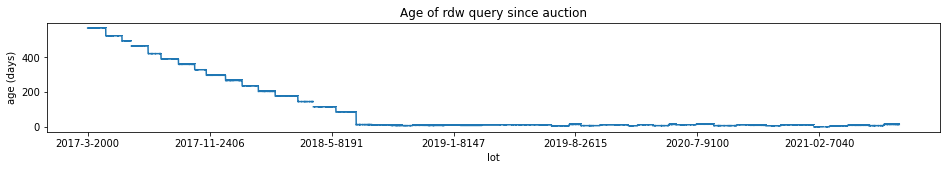

In [30]:
if VERBOSE > 0:
    # plot query age
    sel = car['rdw_ser'].isna()
    car['RDW_age'] = np.NaN
    car.loc[~sel, "RDW_age"] = (car.loc[~sel,'rdw_ser'] - car.now).apply(lambda x:x.days)
    car["RDW_age"].plot(marker=',', figsize=[16,2])
    plt.xlabel('lot')
    plt.ylabel('age (days)')
    plt.title('Age of rdw query since auction')

some old-style (dict) rdw info is retrofitted. In 2021-01 ovi data may have been added.


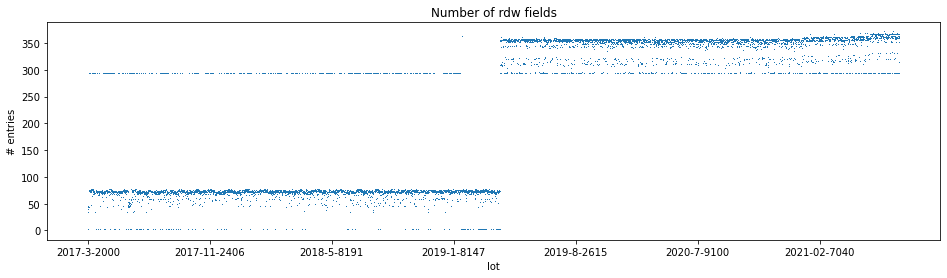

In [31]:
if VERBOSE > 0:
    # Nr of rdw entries
    df_ = pd.DataFrame(index=car.index, columns=['old_style', 'number_of_rdw_entries'])
    df_.old_style = car.rdwinfo.apply(lambda x: isinstance(x, dict))
    sel = df_.old_style
    df_.loc[sel, 'number_of_rdw_entries'] = car.loc[sel, 'rdwinfo'].apply(len)

    rdw_cols = car.columns.str.startswith('rdw_')
    sel = ~df_.old_style
    df_.loc[sel, 'number_of_rdw_entries'] = car.loc[sel, rdw_cols].notna().sum(axis='columns')
    df_.plot(marker=',', linestyle='', figsize=[16,4], legend=False)
    plt.xlabel('lot')
    plt.title('Number of rdw fields')
    plt.ylabel('# entries')
    print('some old-style (dict) rdw info is retrofitted. In 2021-01 ovi data may have been added.')

### Rename RDW info
`<field name>_rdw(ovi)` indicates that RDW field might already exist in the auction info. The suffix prevents overwriting.


In [32]:
# rename rdw fields
Map = {
    "rdw_aantal_cilinders": "nCyl_rdw",
    "rdw_cilinderinhoud": "cylvol_rdw",
    "rdw_aantal_zitplaatsen": "nSeat_rdw",
    "rdw_basisgegevens_aantal_zitplaatsen_bovengrens": "nSeat2_rdw", 
    "rdw_aantal_deuren" : "nDoor_rdw",
    "rdw_basisgegevens_aantal_deuren_bovengrens": "nDoor2_rdw",
    "rdw_breedte": "width_rdw",
    "rdw_lengte": "length_rdw",
    "rdw_wielbasis": "wheelbase_rdw",
    "rdw_massa_ledig_voertuig":"weight_rdw",
    "rdw_basisgegevens_breedte_voertuig_uitvoering_bovengrens": "width2_rdw",
    "rdw_basisgegevens_lengte_voertuig_uitvoering_bovengrens": "length2_rdw",
    "rdw_basisgegevens_wielbais_bovengrens": "wheelbase2_rdw",
    "rdw_basisgegevens_massa_leeg_voertuig_bovengrens": "weight2_rdw",
    "rdw_basisgegevens_hoogte_voertuig_uitvoering_bovengrens": "height_rdw", 
    "rdw_bruto_bpm" : "bpm_rdw",
    "rdw_catalogusprijs": "newprice_rdw",
    "rdw_datum_tenaamstelling": "reglast_str_rdw",
    "rdw_datum_eerste_afgifte_nederland": "regnl_str_rdw",
    "rdw_datum_eerste_toelating": "regfirst_str_rdw",
    "rdw_vervaldatum_apk":"apk_str_rdw",
    "rdw_inrichting":"body2_rdw",
    "rdw_eerste_kleur":"color_rdw",
    "rdw_merk":"brand_rdw",
    "rdw_handelsbenaming":"model_rdw",
    "rdw_taxi_indicator":"taxi_rdw",
    "rdw_basisgegevens_kant_van_het_stuur":"rhd_rdw",
    "rdw_basisgegevens_max_constructie_snelheid_bovengrens": "maxspeed_rdw",
    "rdw_ovi_private_owners": "private_owners_rdwovi",
    "rdw_ovi_company_owner": "company_owners_rdwovi",
    "rdw_ovi_under_survey": "under_survey_rdwovi", #WOK rdw_ovi_wachten_op_keuring parsed
    "rdw_ovi_merk":"brand_rdwovi",
    "rdw_ovi_handelsbenaming":"model_rdwovi",
    "rdw_ovi_aantal_cilinders": "nCyl_rdwovi",
    "rdw_ovi_aantal_deuren": "nDoor_rdwovi",
    "rdw_ovi_aantal_zitplaatsen": "nSeat_rdwovi",
    "rdw_ovi_bpm_bedrag": "bpm_rdwovi",
    "rdw_ovi_breedte": "width_rdwovi",
    "rdw_ovi_catalogus_prijs": "newprice_rdwovi",
    "rdw_ovi_cilinder_inhoud": "cylvol_rdwovi",
    "rdw_ovi_lengte": "length_rdwovi",
    "rdw_ovi_massa_ledig_voertuig": "weight_rdwovi",
    "rdw_ovi_eerste_toelatingsdatum": "regfirst_str_rdwovi",
    "rdw_nettomaximumvermogen": "power2_rdw",
    "rdw_ovi_maximum_constructie_snelheid": "maxspeed_rdwovi",
    "rdw_zuinigheidslabel": "energylab2_rdw",
    "rdw_wacht_op_keuren": "under_survey_rdw", # not provided in open data!
    "rdw_ovi_kleur": "color_rdwovi",

}

# Should all exist in dataframe
assert len(np.setdiff1d(list(Map.keys()), car.columns)) == 0

car.rename(columns=Map, inplace=True)


In [33]:
# aggregate rdw fields with index numbers stored in dicts
#   this can be mean, string join, first or whatever
car['power_rdw'] = car.rdw_brandstof_nettomaximumvermogen_concat.apply(
    lambda x: np.mean(list(x.values())) if len(x) > 0 else np.NaN)

car["milage_rdw"] = car.rdw_brandstof_brandstofverbruik_gecombineerd_concat.apply(
    lambda x: np.mean(list(x.values())) if len(x) > 0 else np.NaN)

car['fuel_rdw'] = car.rdw_brandstof_brandstof_omschrijving_concat.apply(
    lambda x:'/'.join(x.values()) if len(x) > 0 else '')

car['body1_rdw'] = car.rdw_carrosserie_type_carrosserie_europese_omschrijving_concat.apply(
    lambda x: list(x.values())[0] if len(x) > 0 else '')

car['nCyl1_rdw'] = car.rdw_motor_uitvoering_aantal_cilinders_concat.apply(
    lambda x: list(x.values())[0] if len(x) > 0 else np.NaN)

car['cylvol1_rdw'] = car.rdw_motor_uitvoering_cilinderinhoud_cm3_concat.apply(
    lambda x: list(x.values())[0] if len(x) > 0 else np.NaN)

car['automatic_rdw'] = car.rdw_versnellingsbak_uitvoering_type_versnellingsbak_concat.apply(
    lambda x: list(x.values())[0] if len(x) > 0 else np.NaN)

car['energylab_rdw'] = car.rdw_uitvoeringverbruik_per_uitgave_verbruikcategorie_uitvoering_concat.apply(
    lambda x: x[max(x.keys())] if len(x) > 0 else '')

car['hybrid_rdw'] = car.rdw_motor_uitvoering_hybride_elektrisch_voertuig_concat.apply(
    lambda x: list(x.values())[0] if len(x) > 0 else np.NaN)

car['nGear_rdw'] = car.rdw_versnellingsbak_uitvoering_aantal_versnellingen_bovengrens_concat.apply(
    lambda x: x[max(x.keys())] if len(x) > 0 else np.NaN)

# Add LPG specification to fuel
is_lpg = car.fuel_rdw.str.lower().str.contains('lpg')
car.loc[is_lpg, 'fuel_rdw'] = car.loc[is_lpg, ['fuel_rdw', 'rdw_type_gasinstallatie']].apply('/'.join, axis='columns')

if VERBOSE > 1:
    display(car.loc[car['fuel_rdw'].drop_duplicates().index, ['fuel_rdw', 'rdw_brandstof_brandstof_omschrijving_concat', 'rdw_type_gasinstallatie']])
    


In [34]:
# add old style dict entries from rdw as new columns
map_old2new = {
    "aantal_cilinders": "nCyl_rdw",
    "cilinderinhoud": "cylvol_rdw",
    "nettomaximumvermogen": "power_rdw",
    "brandstofverbruik_gecombineerd":"milage_rdw",
    "aantal_zitplaatsen": "nSeat_rdw",
    "aantal_deuren" : "nDoor_rdw",
    "breedte": "width_rdw",
    "lengte": "length_rdw",
    "wielbasis": "wheelbase_rdw",
    "massa_ledig_voertuig":"weight_rdw",
    "bruto_bpm" : "bpm_rdw",
    "catalogusprijs": "newprice_rdw",
    "datum_tenaamstelling": "reglast_str_rdw",
    "datum_eerste_afgifte_nederland": "regnl_str_rdw",
    "datum_eerste_toelating": "regfirst_str_rdw",
    "vervaldatum_apk":"apk_str_rdw",
    "type_carrosserie_europese_omschrijving":"body1_rdw",
    "inrichting":"body2_rdw",
    "brandstof_omschrijving":"fuel_rdw",
    "eerste_kleur":"color_rdw",
    "merk":"brand_rdw",
    "handelsbenaming":"model_rdw",
    "taxi_indicator":"taxi_rdw",
}

for rdw_key, new_column in map_old2new.items():
    
    is_old_style = car.rdwinfo.apply(lambda row: rdw_key in row.keys() if isinstance(row, dict) else False)
    car.rdwinfo[is_old_style].apply(lambda x: x[rdw_key][0]) # Take first. Rdw named first key conveniently '0'
    values = car.rdwinfo[is_old_style].apply(lambda x: list(x[rdw_key].values()))

    if VERBOSE > 0:
        print(f'{rdw_key:40s} -> {new_column}')
        
    if values.apply(len).max() == 1:
        # Column should exist. Hence insert with mask
        car.loc[is_old_style, new_column] = values.apply(lambda x: x[0])

    elif new_column == 'fuel_rdw':
        order = car.rdwinfo[is_old_style].apply(lambda x: list(x['brandstof_volgnummer'].values()))
        ordered_values = [[v[i-1] for i in o] for o, v in zip(order, values)]
        concat_values = [*map('/'.join, ordered_values)]
        tank_type = car.rdwinfo[is_old_style].apply(lambda x: list(x['type_gasinstallatie'].values()) if "type_gasinstallatie" in x else []) # will include CNG
        fuel = pd.Series({i: f + '/' + '/'.join(tank_type.loc[i]) if len(tank_type.loc[i]) > 0 else f for f, i in zip(concat_values, tank_type.index)})
        car.loc[is_old_style, new_column] = fuel

    if VERBOSE > 1:
        try:
            print(car.loc[is_old_style, new_column].value_counts().sort_index())
        except TypeError:
            print(car.loc[is_old_style, new_column].astype(str).value_counts().sort_index())




aantal_cilinders                         -> nCyl_rdw
cilinderinhoud                           -> cylvol_rdw
nettomaximumvermogen                     -> power_rdw
brandstofverbruik_gecombineerd           -> milage_rdw
aantal_zitplaatsen                       -> nSeat_rdw
aantal_deuren                            -> nDoor_rdw
breedte                                  -> width_rdw
lengte                                   -> length_rdw
wielbasis                                -> wheelbase_rdw
massa_ledig_voertuig                     -> weight_rdw
bruto_bpm                                -> bpm_rdw
catalogusprijs                           -> newprice_rdw
datum_tenaamstelling                     -> reglast_str_rdw
datum_eerste_afgifte_nederland           -> regnl_str_rdw
datum_eerste_toelating                   -> regfirst_str_rdw
vervaldatum_apk                          -> apk_str_rdw
type_carrosserie_europese_omschrijving   -> body1_rdw
inrichting                               -> body2_rdw
b

## preprocessing of rdw info

In [35]:
map_str2date = {
    "regfirst_str_rdw":"regfirst_rdw",
    "regnl_str_rdw":"regnl_rdw",
    "reglast_str_rdw":"reglast_rdw",
    "apk_str_rdw":"apk_rdw",
}

if VERBOSE > 1:
    gb_ = car[[*map_str2date.keys()]].groupby([*map(lambda x: '{0}-{1:>2s}'.format(*x.split('-')[0:2]), car.index)])
    df_ = pd.concat([
        gb_.first(),
        gb_.first().applymap(type)
    ], axis=1)
    display(df_)

# lookup table when format changed
date_format = pd.DataFrame(columns=['start', 'end', 'pattern'])
date_format = date_format.append(pd.DataFrame(columns=date_format.columns, index=['pat1', 'pat2', 'pat3'], 
                                              data=[
                                                  ['1769-1-1', '2019-03-01', '%d/%m/%Y'], #25/11/2008
                                                  ['2019-03-01', '2019-04-01', [lambda x: f'{x:.0f}', '%Y%m%d']],#20021112 convert to string first
                                                  ['2019-04-01', '2100-01-01', [lambda x: f'{x:.0f}', '%Y%m%d']] #2.00902e+07
                                              ]))
query_date = car.rdw_ser.fillna(pd.NaT)

# Loop over columns that need transforming
for rdw_key, new_column in map_str2date.items():

    car[new_column] = pd.NaT

    if VERBOSE > 0:
        print(f'{rdw_key:10s} -> {new_column}')

    # Do per formatting version
    for date_fmt in date_format.iterrows():
        if VERBOSE > 1:
            print(f'{date_fmt[0]}: ')
            for k,v in date_fmt[1].items():
                print(f'\t{k}: {v}')

        # Select rows with formatting
        sel = (query_date >= date_fmt[1].start) & (query_date < date_fmt[1].end)
        old_fmt = car.loc[sel, rdw_key]

        if VERBOSE > 1:
            print('Query dates (check with start, end):')
            print(f'\t{query_date[sel].min().strftime("%Y-%m-%d")} .. {query_date[sel].max().strftime("%Y-%m-%d")}')
            print(f'Format in {rdw_key} (check with pattern):')
            print(f'\t{old_fmt[sel][0]} .. {old_fmt[sel][-1]}')

        # Convert to datetime. Optionally apply modifier if list.
        if isinstance(date_fmt[1].pattern, list):
            for fun in date_fmt[1].pattern[:-1]:
                old_fmt = old_fmt.apply(fun)
            date_pat = date_fmt[1].pattern[-1]
        else:
            date_pat = date_fmt[1].pattern

        # Update dataframe
        new_fmt = old_fmt.apply(lambda d: pd.to_datetime(d, format=date_pat))
        new_fmt.name = new_column    
        car[new_column].update(new_fmt)
        if VERBOSE > 1:
            print(f'{car[new_column].dropna().shape[0]} of {car.shape[0]} are modified after applying {date_fmt[0]}')

# remove string values (old columns)
car.drop(columns=map_str2date.keys(), inplace = True)

# Ovi data has format 0d-0m-yyyy
map_str2date = {
    "regfirst_str_rdwovi":"regfirst_rdwovi",
}

for rdw_key, new_column in map_str2date.items():

    car[new_column] = pd.NaT

    if VERBOSE > 0:
        print(f'{rdw_key:10s} -> {new_column}')

    car[new_column].update(
        car[rdw_key].replace('', np.NaN).dropna()\
        .apply(lambda d: pd.to_datetime(d, format="%d-%m-%Y"))
    )
    
# drop old columns
car.drop(columns=map_str2date.keys(), inplace = True)


regfirst_str_rdw -> regfirst_rdw
regnl_str_rdw -> regnl_rdw
reglast_str_rdw -> reglast_rdw
apk_str_rdw -> apk_rdw
regfirst_str_rdwovi -> regfirst_rdwovi


In [36]:
# Add age if column contains date
age = car[map_str2date.values()].apply(lambda c: car.now - c).add_suffix('_age')
if all(age.columns.isin(car.columns)):
    car.update(age)
else:
    car = pd.concat([car, age], axis=1)


In [37]:
# same data type
# sometimes type is numerical
car.model_rdw = car.model_rdw.astype(str)
car.brand_rdw = car.brand_rdw.astype(str)


In [38]:
# lower case
cols = ['body1_rdw', 'body2_rdw', 'fuel_rdw', 'model_rdw', 'model_rdwovi']
car[cols] = car[cols].apply(lambda x: x.str.lower())

In [39]:
# strip brand from model
def remove_brand(model,brand):
    '''remove trailing brand name from model name'''
    
    import re
    
    if type(model) == str:
        model = re.sub('(?i)^' + brand + '[ ,;]*','',model)
    return model 

# special cases
selJag = car.brand_rdw == 'JAGUAR CARS'
selCit = car.brand_rdw == 'CITROEN' 

# remove brand name
for col in ['model_drz', 'model_rdw', 'model_rdwovi']:
    car[col] = car.apply(lambda row:remove_brand(row[col], row.brand_rdw),axis='columns')

    car.loc[selJag,col] = car.loc[selJag,:].apply(lambda row:remove_brand(row[col],'JAGUAR'), axis='columns')
    car.loc[selCit,col] = car.loc[selCit,:].apply(lambda row:remove_brand(row[col],'CITROËN'), axis='columns')
    car.loc[selCit,col] = car.loc[selCit,:].apply(lambda row:remove_brand(row[col],'citroÃ«n'), axis='columns')


In [40]:
# category to boolean
car.rhd_rdw = car.rhd_rdw.replace({'R': True, 'L': False})
car.automatic_rdw = car.automatic_rdw.replace({'A': True, 'H': False, 'C': True})
car.hybrid_rdw = car.hybrid_rdw.replace({'J': True, 'N': False})
car.taxi_rdw = car.taxi_rdw.replace({'Ja': True, 'Nee': False})
#rdw_hefas 

In [41]:
# consistent with other fields

# m to cm
car.wheelbase_rdw = car.wheelbase_rdw * 10.0 
car.length_rdw = car.length_rdw * 10.0
car.width_rdw = car.width_rdw * 10.0

car.length_rdwovi = car.length_rdwovi.str.replace(r' cm$','', regex=True).astype(float)*10.0
car.width_rdwovi = car.width_rdwovi.str.replace(r' cm$','', regex=True).astype(float)*10.0

In [42]:
# Numerical fields
# weight, width, length, height, etc
for fld in [
    'length_rdw',
    'width_rdw',
    'nDoor_rdw',
    'nDoor2_rdw',
    'length_rdwovi',
    'width_rdwovi',
    
]:
    if car[fld].dtype == 'int':
        car[fld] = car[fld].replace({0: -1})
        if VERBOSE > 0:
            print(f'replace 0 with -1 in {fld}')
    elif car[fld].dtype == 'float':
        car[fld] = car[fld].replace({0.0: np.NaN})
        if VERBOSE > 0:
            print(f'replace 0.0 with NaN in {fld}')
    else:
        print(fld, car[fld].dtype)
        raise TypeError

        
if VERBOSE > 1:
    print('These have zeros that possibly need replacing too')
    print([c for c in car.columns if (car[c]==0).any()])


replace 0.0 with NaN in length_rdw
replace 0.0 with NaN in width_rdw
replace 0 with -1 in nDoor_rdw
replace 0 with -1 in nDoor2_rdw
replace 0.0 with NaN in length_rdwovi
replace 0.0 with NaN in width_rdwovi


### Use auction info or RDW info

In [43]:
fldpairs = [
    ['taxi_rdw','taxi_drz','taxi'],
    ['regfirst_rdw','regfirst_rdwovi','MF_drz','MF'],
    ['apk_drz','apk_rdw','apk'],
    ['body1_rdw','body2_rdw','bodytype'],
    ['fuel_rdw','fuel_drz','fuel'],
    ['brand_drz','brand_rdw', 'brand_rdwovi', 'brand'],
    ['model_drz','model_rdw', 'model_rdwovi', 'model'],
    ['nDoor2_rdw', 'nDoor_rdw', 'nDoor_rdwovi', 'nDoor'],
    ['nSeat2_rdw', 'nSeat_rdw', 'nSeat_rdwovi', 'nSeat'],
    ['nCyl1_rdw', 'nCyl_rdw', 'nCyl_rdwovi', 'nCyl'],
    ['cylvol1_rdw', 'cylvol_rdw', 'cylvol_rdwovi', 'cylvol'],
    ['rhd_drz', 'rhd_rdw', 'rhd'],
    ['wheelbase2_rdw', 'wheelbase_rdw', 'wheelbase'],
    ['width2_rdw', 'width_rdw', 'width_rdwovi', 'width'],
    ['length2_rdw', 'length_rdw', 'length_rdwovi', 'length'],
    ['weight2_rdw', 'weight_rdw', 'weight_rdwovi', 'weight'],
    ['automatic_drz', 'automatic_rdw', 'automatic'],
    ['hybrid_rdw', 'hybrid_drz', 'hybrid'],
    ['bpm_rdw', 'bpm_rdwovi', 'bpm'],
    ['newprice_rdw', 'newprice_rdwovi', 'newprice'],
    ['power_rdw', 'power2_rdw', 'power'],
    ['maxspeed_rdw', 'maxspeed_rdwovi', 'maxspeed'],
    ['height_rdw', 'height_rdw', 'height'], # mock compare to trim suffix
    ['nGear_rdw', 'nGear_rdw', 'nGear'], # i.d.
    ['private_owners_rdwovi', 'private_owners_rdwovi', 'private_owners'], # i.d.
    ['company_owners_rdwovi', 'company_owners_rdwovi', 'company_owners'], # i.d.    
    ['modelspec_drz','modelspec_drz', 'modelspec'], #i.d.    
    ['energylab_rdw', 'energylab2_rdw', 'energylab'],
    ['under_survey_rdwovi', 'under_survey_rdw', 'under_survey'],
    ['color_rdw', 'color_rdwovi', 'color'],
]


for flds in fldpairs:

    # add result field if not exist
    if flds[-1] not in car.columns:
        df_ = car.loc[:, flds[:-1]]
        df_[flds[-1]] = np.NaN
    else:
        df_ = car.loc[:, flds]

    # replace placeholders with NaN
    df_.replace({
        'niet geregistreerd': np.NaN, 
        '': np.NaN,
        -1: np.NaN,
        'nan': np.NaN,
    }, inplace=True)

    # branch off df for display
    df_disp = df_.copy()
    df_disp.fillna('', inplace=True)

    # select rows that are not all (but one) NaN
    notallna = df_.iloc[:,:-1].notna().sum(axis=1) > 1
    
    # start filling values from left to right
    df_ = df_.bfill(axis=1)
    
    # Last value is result
    choice = df_.iloc[:,0]
    choice.name = f'>{flds[-1]}<'
    car[flds[-1]] = choice # <- UPDATE DATA
    
    # display differences
    
    if VERBOSE > 0:
        # accented are same
        if flds[-1] == 'brand':
            df_.replace({'CITROËN': 'CITROEN'}, inplace=True)
        # add extra info
        if flds[-1] == 'model':
            df_disp = pd.concat([
                car.loc[: ,['brand_rdw', 'brand']].ffill(axis=1).iloc[:,-1], 
                car.modelspec_drz,
                df_disp], axis=1)

        df_disp = pd.concat([df_disp, choice], axis=1)

        nuq = df_.iloc[:,:-1].nunique(axis=1, dropna=True)
        isdiff = (nuq > 1) & notallna


        if all(~isdiff):
            print(f'{flds[-1]}: same in all auctions {flds[:-1]}')
        else:
            if VERBOSE > 1:
                display(df_disp[isdiff])
            else:
                # only current auction
                islast = df_disp.index.str.startswith('-'.join(df_disp.index[-1].split('-')[:-1]))
                if all(~(isdiff & islast)):
                    print(f'{flds[-1]}: same in last auctions {flds[:-1]}')
                else:
                    display(df_disp[isdiff & islast])


taxi: same in last auctions ['taxi_rdw', 'taxi_drz']
MF: same in last auctions ['regfirst_rdw', 'regfirst_rdwovi', 'MF_drz']
apk: same in last auctions ['apk_drz', 'apk_rdw']


,body1_rdw,body2_rdw,bodytype,>bodytype<
2021-06-7011,bestelwagen,gesloten opbouw,,bestelwagen


,fuel_rdw,fuel_drz,fuel,>fuel<
2021-06-7001,alcohol/benzine,benzine,,alcohol/benzine
2021-06-7018,benzine/elektriciteit,benzine,,benzine/elektriciteit
2021-06-7071,benzine/lpg/g3 gasinstallatie,benzine,,benzine/lpg/g3 gasinstallatie
2021-06-7097,benzine/elektriciteit,benzine,,benzine/elektriciteit
2021-06-7101,benzine/lpg/g3 gasinstallatie,lpg,,benzine/lpg/g3 gasinstallatie


,brand_drz,brand_rdw,brand_rdwovi,brand,>brand<
2021-06-2205,MERCEDES-BENZ,MERCEDES-AMG,MERCEDES-AMG,,MERCEDES-BENZ


,brand,modelspec_drz,model_drz,model_rdw,model_rdwovi,model,>model<
2021-06-7002,PEUGEOT,,307 cc 2.0 16v,307,307,,307 cc 2.0 16v
2021-06-7171,MERCEDES-BENZ,,450 s.l.c.,450s.l.c.,450s.l.c.,,450 s.l.c.


nDoor: same in last auctions ['nDoor2_rdw', 'nDoor_rdw', 'nDoor_rdwovi']
nSeat: same in last auctions ['nSeat2_rdw', 'nSeat_rdw', 'nSeat_rdwovi']
nCyl: same in all auctions ['nCyl1_rdw', 'nCyl_rdw', 'nCyl_rdwovi']
cylvol: same in all auctions ['cylvol1_rdw', 'cylvol_rdw', 'cylvol_rdwovi']


,rhd_drz,rhd_rdw,rhd,>rhd<
2021-06-7136,False,M,,False


,wheelbase2_rdw,wheelbase_rdw,wheelbase,>wheelbase<
2021-06-2200,2812.0,2810.0,,2812.0
2021-06-2201,2729.0,2730.0,,2729.0
2021-06-7000,2715.0,2720.0,,2715.0
2021-06-7002,2605.0,2610.0,,2605.0
2021-06-7005,2675.0,2680.0,,2675.0
2021-06-7014,2455.0,2460.0,,2455.0
2021-06-7016,2778.0,2780.0,,2778.0
2021-06-7017,2455.0,2460.0,,2455.0
2021-06-7018,2629.0,2630.0,,2629.0
2021-06-7020,2807.0,2810.0,,2807.0


,width2_rdw,width_rdw,width_rdwovi,width,>width<
2021-06-7125,1829.0,1830.0,,,1829.0
2021-06-7143,1627.0,1630.0,,,1627.0
2021-06-7160,1877.0,1880.0,,,1877.0
2021-06-7173,1881.0,1880.0,,,1881.0


,length2_rdw,length_rdw,length_rdwovi,length,>length<
2021-06-2200,4671.0,4670.0,,,4671.0
2021-06-2201,4688.0,4690.0,,,4688.0
2021-06-2205,4756.0,4760.0,,,4756.0
2021-06-7001,4522.0,4520.0,,,4522.0
2021-06-7002,4349.0,4350.0,,,4349.0
2021-06-7003,3445.0,3450.0,,,3445.0
2021-06-7006,4624.0,4620.0,,,4624.0
2021-06-7010,4324.0,4320.0,,,4324.0
2021-06-7015,4245.0,4250.0,,,4245.0
2021-06-7026,3828.0,3830.0,,,3828.0


weight: same in all auctions ['weight2_rdw', 'weight_rdw', 'weight_rdwovi']


,automatic_drz,automatic_rdw,automatic,>automatic<
2021-06-7093,True,G,,True


,hybrid_rdw,hybrid_drz,hybrid,>hybrid<
2021-06-7018,True,False,,True
2021-06-7097,True,False,,True


bpm: same in all auctions ['bpm_rdw', 'bpm_rdwovi']
newprice: same in all auctions ['newprice_rdw', 'newprice_rdwovi']
power: same in all auctions ['power_rdw', 'power2_rdw']
maxspeed: same in all auctions ['maxspeed_rdw', 'maxspeed_rdwovi']
height: same in all auctions ['height_rdw', 'height_rdw']
nGear: same in all auctions ['nGear_rdw', 'nGear_rdw']
private_owners: same in all auctions ['private_owners_rdwovi', 'private_owners_rdwovi']
company_owners: same in all auctions ['company_owners_rdwovi', 'company_owners_rdwovi']
modelspec: same in all auctions ['modelspec_drz', 'modelspec_drz']


,energylab_rdw,energylab2_rdw,energylab,>energylab<
2021-06-7002,E,D,,E
2021-06-7003,D,A,,D
2021-06-7005,G,D,,G
2021-06-7006,D,A,,D
2021-06-7007,F,E,,F
2021-06-7010,F,C,,F
2021-06-7014,C,A,,C
2021-06-7017,C,B,,C
2021-06-7021,C,G,,C
2021-06-7024,D,A,,D


under_survey: same in all auctions ['under_survey_rdwovi', 'under_survey_rdw']


,color_rdw,color_rdwovi,color,>color<
2021-06-7129,GRIJS,GRIJS / ZWART,,GRIJS


- - - - 
# calculate extra info

In [44]:
# four wheel drive
car['fwd'] = car.rdw_basisgegevens_aantal_aangedreven_assen.replace({-1: '', 0: False, 1: False})
sel = car.fwd.apply(lambda x: x>1 if type(x)==int else False)
car.loc[sel,'fwd'] = True

In [45]:
car["Age"] = (car["now"] - car["MF"]).apply(lambda x: x.days)
car["APK_age"] = (car["now"] - car["apk"]).apply(lambda x: x.days)
car["import_age"] = (car["regnl_rdw"] - car["regfirst_rdw"]).apply(lambda x: x.days)

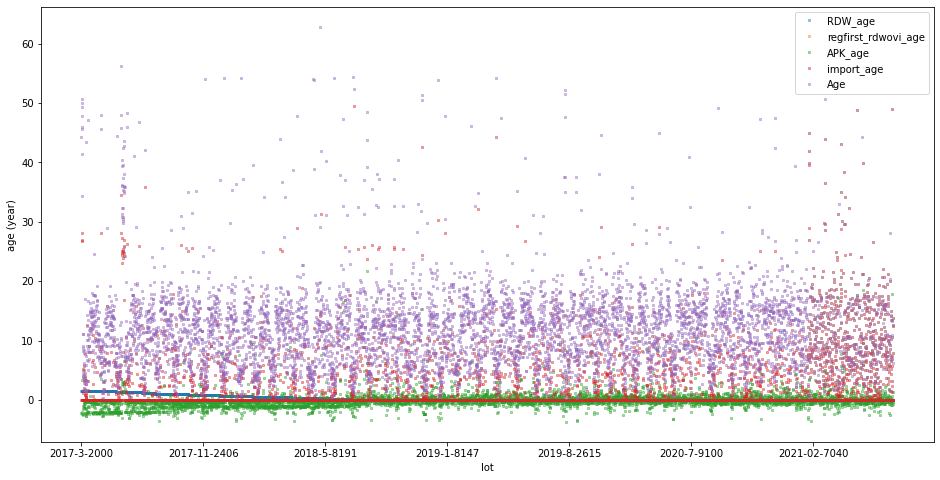

In [46]:
# plot
if VERBOSE > 1:
    df_ = car[[c for c in car.columns if c.endswith('_age')] + ['Age']]\
    .applymap(lambda x: x.days/365.25 if isinstance(x, pd.Timedelta) else x/365.25)\
    .replace({pd.NaT: np.nan})
    
    for k,s in df_.iteritems():
        plt.figure(figsize=[16,2])
        s.plot(marker=',', linestyle='', alpha=1, figsize=[16,2], ms=2)
        plt.title(k)
        
    plt.ylabel('age (year)')
    
elif VERBOSE > 0:
    car[[c for c in car.columns if c.endswith('_age')] + ['Age']]\
    .applymap(lambda x: x.days/365.25 if isinstance(x, pd.Timedelta) else x/365.25)\
    .replace({pd.NaT: np.nan})\
    .plot(marker='s', linestyle='', alpha=0.4, figsize=[16,8], ms=2)
    plt.legend()   
    plt.xlabel('lot')
    plt.ylabel('age (year)')
    


# subselection and save

### Save data for ML

In [47]:
save_cols = [
    "Price",
    "brand",
    "model",
    "Age",
    "fuel",
    "Odo",
    "APK_age",
    "import_age",
    "bodytype",
    "cylvol",
    "nCyl",
    "power",
    "weight",
    "bpm",
    "newprice",
    "nSeat",
    "nDoor", 
    "color",
    'fwd',
    'maxspeed',
    'length',
    'height',
    'width',
    'automatic',
    'nGear',
    'energylab',
    'private_owners',
    'company_owners',
    'under_survey',
]
map_lowercase = {
    'Price':'price',
    'Age':'age',
    'Odo':'odometer',
    'APK_age':'days_since_inspection_invalid',
    'import_age':'age_at_import',
    'bodytype':'body_type',
    'cylvol':'displacement',
    'nCyl':'number_of_cylinders',
    'bpm':'registration_tax',
    'newprice':'sale_price',
    'nSeat':'number_of_seats',
    'nDoor':'number_of_doors',
    'maxspeed':'top_speed',
    'automatic':'automatic_gearbox',
    'nGear':'number_of_gears',
    'energylab': 'energy_label',
}

if VERBOSE > 1:
    print('Columns >> .. << are saved as car dataset')
    
    ncol = 8
    l = [*car.columns]
    l = sorted(l)
    l = [f'>> {i} <<' if i in save_cols else i for i in l]
    l_padded = np.ceil(len(l) / ncol)*ncol
    l += [''] * int(l_padded - len(l))
    df_ = pd.DataFrame(np.reshape(l, (-1,ncol)), columns = [''] * ncol)
    df_['ix'] = ''
    df_.set_index('ix', inplace=True)
    df_.index.name=''
    with pd.option_context("display.max_rows", 999, "max_colwidth", 32):
        display(df_)

out = car.loc[:,save_cols].rename(columns=map_lowercase)
if VERBOSE > 0:
    with pd.option_context("display.max_columns", 999):
        display(out.tail())

# save data
if OPBOD:
    file_name = '../../../python-nb/data/cars-for-ml-opbod.pkl'
else:
    file_name = '../data/cars-for-ml.pkl'

# save
if (SKIPSAVE==False): # and (not(os.path.isfile(file_name))):
    print(file_name)
    out.to_pickle(file_name)
else:
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    


,price,brand,model,age,fuel,odometer,days_since_inspection_invalid,age_at_import,body_type,displacement,number_of_cylinders,power,weight,registration_tax,sale_price,number_of_seats,number_of_doors,color,fwd,top_speed,length,height,width,automatic_gearbox,number_of_gears,energy_label,private_owners,company_owners,under_survey
2021-06-7175,4500.0,VOLKSWAGEN,golf,2266.0,diesel,118686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
2021-06-7176,3486.0,VOLKSWAGEN,up,2899.0,benzine,110616.0,25.0,0.0,hatchback,999.0,3.0,44.0,840.0,0.0,8684.0,4.0,NaN,WIT,False,161.0,3543.0,1504.0,1645.0,False,5.0,C,3.0,0.0,False
2021-06-7178,999.0,PEUGEOT,207,4631.0,diesel,283224.0,-148.0,0.0,stationwagen,1560.0,4.0,80.0,1287.0,6525.0,25988.0,5.0,4.0,GRIJS,False,188.0,4156.0,1555.0,1748.0,False,5.0,C,3.0,0.0,False
2021-06-7179,8105.0,AUDI,q5,4520.0,benzine,259372.0,-228.0,0.0,stationwagen,1984.0,4.0,155.0,1715.0,17646.0,73975.0,5.0,4.0,ZWART,True,222.0,4743.0,1663.0,1934.0,True,7.0,C,3.0,1.0,False
2021-06-7181,839.0,OPEL,corsa,5025.0,diesel,213537.0,504.0,0.0,mpv,1248.0,4.0,55.0,1105.0,5167.0,19546.0,5.0,2.0,GRIJS,False,163.0,4040.0,1488.0,1713.0,False,5.0,C,3.0,0.0,False


../data/cars-for-ml.pkl


### Save data for image classification

In [48]:
save_cols = [
    "Images",
    "brand",
    "model",
    "modelspec",
    "color",
    "Age",
    "bodytype",
    "cabriolet",
    "nDoor", 
    "length", 
    'height',
    'width',
    "wheelbase",
    "ForeignReg",
    "Reg",
    "taxi",
]
map_lowercase = {
    'Images':'image_urls',
    'modelspec':'model_specification',
    'Age':'age',
    'bodytype':'body_type',
    'cabriolet':'convertible',
    'nDoor':'number_of_doors',
    'ForeignReg':'foreign_registration',
    'Reg':'registration_number'
}

out = car.loc[:,save_cols].rename(columns=map_lowercase)
if VERBOSE > 0:
    with pd.option_context("display.max_columns", 999):
        display(out.tail())


# save data
if OPBOD:
    file_name = '../../../python-nb/data/cars-for-imageclf-opbod.pkl'
else:
    file_name = '../data/cars-for-imageclf.pkl'


# save
if (SKIPSAVE==False): # and (not(os.path.isfile(file_name))):
    print(file_name)
    out.to_pickle(file_name)
else:
    print(f'Skip. {file_name} exists or saving is disabled in settings.')    

,image_urls,brand,model,model_specification,color,age,body_type,convertible,number_of_doors,length,height,width,wheelbase,foreign_registration,registration_number,taxi
2021-06-7175,[http://verkoop.domeinenrz.nl/ufc/static/16226...,VOLKSWAGEN,golf,NaN,NaN,2266.0,NaN,False,NaN,NaN,NaN,NaN,NaN,Frans,,False
2021-06-7176,[http://verkoop.domeinenrz.nl/ufc/static/16226...,VOLKSWAGEN,up,NaN,WIT,2899.0,hatchback,False,NaN,3543.0,1504.0,1645.0,2407.0,,1-KRD-62,False
2021-06-7178,[http://verkoop.domeinenrz.nl/ufc/static/16226...,PEUGEOT,207,NaN,GRIJS,4631.0,stationwagen,False,4.0,4156.0,1555.0,1748.0,2540.0,,46-GVL-9,False
2021-06-7179,[http://verkoop.domeinenrz.nl/ufc/static/16226...,AUDI,q5,NaN,ZWART,4520.0,stationwagen,False,4.0,4743.0,1663.0,1934.0,2815.0,,19-HKK-6,False
2021-06-7181,[http://verkoop.domeinenrz.nl/ufc/static/16226...,OPEL,corsa,NaN,GRIJS,5025.0,mpv,False,2.0,4040.0,1488.0,1713.0,2511.0,,58-XR-HD,False


../data/cars-for-imageclf.pkl


# Write example table to file
based on: https://stackoverflow.com/a/33869154

In [49]:
def pandas_df_to_markdown_table(df):
    fmt = ['-----' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return df_formatted.to_csv(sep="|", index=False)


In [50]:
fn = '../data/cars-for-ml.pkl'
print(f'load {fn}')
out = pd.read_pickle(fn)

file_name = '../assets/example-table-of-ml.md'
example = out.tail(10).copy()
# trim some long fields
example.rdwinfo = '.. rdw info ..'
example.Raw_text = '.. raw text ..'
example.SupInfo = '.. suplm. info. ..'

# convert to md
try:
    table_text = example.reset_index().to_markdown()
except ImportError:
    print('Fallback')
    table_text = pandas_df_to_markdown_table(example.reset_index())

# save
if (SKIPSAVE==False) and (not(os.path.isfile(file_name))):
    with open(file_name,'w') as file:
        file.write(table_text)

    print('A markdown table is available as\n\t{}'.format(file_name))
else:
    print(f'Skip. {file_name} exists or saving is disabled in settings.')
    display(example)
    

load ../data/cars-for-ml.pkl
Skip. ../assets/example-table-of-ml.md exists or saving is disabled in settings.


,price,brand,model,age,fuel,odometer,days_since_inspection_invalid,age_at_import,body_type,displacement,...,top_speed,length,height,width,automatic_gearbox,number_of_gears,energy_label,private_owners,company_owners,under_survey
2021-06-7168,1290.0,OPEL,zafira,4011.0,diesel,309861.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
2021-06-7169,14861.0,RENAULT,scenic,1175.0,benzine,20042.0,-286.0,842.0,hatchback,1197.0,...,195.0,4635.0,1648.0,1866.0,False,6.0,C,1.0,0.0,False
2021-06-7171,3772.0,MERCEDES-BENZ,450 s.l.c.,17868.0,lpg/,244010.0,6506.0,500.0,NaN,0.0,...,NaN,NaN,NaN,NaN,True,NaN,NaN,2.0,0.0,False
2021-06-7173,14389.0,MERCEDES-BENZ,cls 250 cdi,2707.0,diesel,162515.0,237.0,2100.0,stationwagen,2143.0,...,235.0,5093.0,1424.0,1881.0,True,7.0,E,2.0,0.0,False
2021-06-7174,4469.0,PEUGEOT,308,2528.0,diesel,190372.0,43.0,0.0,hatchback,1560.0,...,183.0,4253.0,1472.0,1804.0,False,5.0,D,3.0,1.0,False
2021-06-7175,4500.0,VOLKSWAGEN,golf,2266.0,diesel,118686.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
2021-06-7176,3486.0,VOLKSWAGEN,up,2899.0,benzine,110616.0,25.0,0.0,hatchback,999.0,...,161.0,3543.0,1504.0,1645.0,False,5.0,C,3.0,0.0,False
2021-06-7178,999.0,PEUGEOT,207,4631.0,diesel,283224.0,-148.0,0.0,stationwagen,1560.0,...,188.0,4156.0,1555.0,1748.0,False,5.0,C,3.0,0.0,False
2021-06-7179,8105.0,AUDI,q5,4520.0,benzine,259372.0,-228.0,0.0,stationwagen,1984.0,...,222.0,4743.0,1663.0,1934.0,True,7.0,C,3.0,1.0,False
2021-06-7181,839.0,OPEL,corsa,5025.0,diesel,213537.0,504.0,0.0,mpv,1248.0,...,163.0,4040.0,1488.0,1713.0,False,5.0,C,3.0,0.0,False


In [51]:
fn = '../data/cars-for-imageclf.pkl'
print(f'load {fn}')
out = pd.read_pickle(fn)

file_name = '../assets/example-table-of-imageclf.md'
example = out.tail(10).copy()
# trim some long fields
example.rdwinfo = '.. rdw info ..'
example.Raw_text = '.. raw text ..'
example.SupInfo = '.. suplm. info. ..'


# convert to md
try:
    table_text = example.reset_index().to_markdown()
except ImportError:
    print('Fallback')
    table_text = pandas_df_to_markdown_table(example.reset_index())

# save
if (SKIPSAVE==False) and (not(os.path.isfile(file_name))):
    with open(file_name,'w') as file:
        file.write(table_text)

    print('A markdown table is available as\n\t{}'.format(file_name))
else:
    print(f'Skip. {file_name} exists or saving is disabled in settings.')
    display(example)
    

load ../data/cars-for-imageclf.pkl
Skip. ../assets/example-table-of-imageclf.md exists or saving is disabled in settings.


,image_urls,brand,model,model_specification,color,age,body_type,convertible,number_of_doors,length,height,width,wheelbase,foreign_registration,registration_number,taxi
2021-06-7168,[http://verkoop.domeinenrz.nl/ufc/static/16226...,OPEL,zafira,NaN,NaN,4011.0,NaN,False,NaN,NaN,NaN,NaN,NaN,Duits,,False
2021-06-7169,[http://verkoop.domeinenrz.nl/ufc/static/16226...,RENAULT,scenic,NaN,GRIJS,1175.0,hatchback,False,5.0,4635.0,1648.0,1866.0,2804.0,,TN-094-K,False
2021-06-7171,[http://verkoop.domeinenrz.nl/ufc/static/16226...,MERCEDES-BENZ,450 s.l.c.,NaN,BRUIN,17868.0,NaN,False,2.0,NaN,NaN,NaN,2820.0,,KH-08-RS,False
2021-06-7173,[http://verkoop.domeinenrz.nl/ufc/static/16226...,MERCEDES-BENZ,cls 250 cdi,NaN,GRIJS,2707.0,stationwagen,False,4.0,5093.0,1424.0,1881.0,2874.0,,G-859-JR,False
2021-06-7174,[http://verkoop.domeinenrz.nl/ufc/static/16226...,PEUGEOT,308,NaN,ZWART,2528.0,hatchback,False,4.0,4253.0,1472.0,1804.0,2620.0,,2-XDB-90,False
2021-06-7175,[http://verkoop.domeinenrz.nl/ufc/static/16226...,VOLKSWAGEN,golf,NaN,NaN,2266.0,NaN,False,NaN,NaN,NaN,NaN,NaN,Frans,,False
2021-06-7176,[http://verkoop.domeinenrz.nl/ufc/static/16226...,VOLKSWAGEN,up,NaN,WIT,2899.0,hatchback,False,NaN,3543.0,1504.0,1645.0,2407.0,,1-KRD-62,False
2021-06-7178,[http://verkoop.domeinenrz.nl/ufc/static/16226...,PEUGEOT,207,NaN,GRIJS,4631.0,stationwagen,False,4.0,4156.0,1555.0,1748.0,2540.0,,46-GVL-9,False
2021-06-7179,[http://verkoop.domeinenrz.nl/ufc/static/16226...,AUDI,q5,NaN,ZWART,4520.0,stationwagen,False,4.0,4743.0,1663.0,1934.0,2815.0,,19-HKK-6,False
2021-06-7181,[http://verkoop.domeinenrz.nl/ufc/static/16226...,OPEL,corsa,NaN,GRIJS,5025.0,mpv,False,2.0,4040.0,1488.0,1713.0,2511.0,,58-XR-HD,False
